In [1]:
from nltk.tokenize import word_tokenize
from collections import Counter
import collections
import sys
import MeCab
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn import cross_validation
from sklearn import datasets
from sklearn import svm
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


C:\Users\fmv\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#元の文書から名詞限定の文書を用意する
mecab = MeCab.Tagger()
def tokenize(text):
    with open(text, 'r')as f:
        textdata=f.read()#一括で詠み込む  
        textdata = re.split('-{5,}', textdata)[0]+ re.split('-{5,}', textdata)[2]
        textdata = re.split('底本', textdata)[0]
        #詠み込んだ文章を底本部分で分割し本文のみを取得
        textdata = re.split('［＃ここから', textdata)[0]
        #詠み込んだ文章を［＃ここから　部分で分割し本文のみを取得
        lines = textdata.split("\r\n")#改行で分ける
        
        results = []
        for line in lines:
            # 学習に使わない表現の削除処理
            s = line
            s = re.sub('｜', '',s)
            s = re.sub('《.+?》', '', s)# 《》を消す
            s = re.sub('［.+?］', '', s)#[]
            s = re.sub('（.+?）', '', s)#()

            token_list=[]
            node = mecab.parseToNode(s)#parseToNode()を使うと形態素の詳細情報
    
            while node:#ループにして情報を取得していく
                # 語を取得
                word = node.surface#surfaceで表層形
                # 品詞を取得
                part = node.feature.split(",")[0]#featureで形態素情報　[0]で品詞取得

                if part in ["名詞"]:#取得した品詞が一致するなら
                     token_list.append(word)#リストに追加   
                node = node.next
            rl = (" ".join(token_list)).strip()
            results.append(rl)
        w_file = "result_"+text
        with open(w_file, 'w', encoding='utf-8') as wf:
            wf.write("\n".join(results))  

#小泉八雲
tokenize('yukionna.txt') 
tokenize('noctilucae.txt') 
tokenize('hashino_uede.txt') 
tokenize('a_dead_secret.txt') 
tokenize('at_a_railway_station.txt') 
#夏目漱石による小説を5つ程度用意
tokenize('ichiya.txt') 
tokenize('yukionna.txt') 
tokenize('carlyle_hakubutsukan.txt') 
tokenize('gubijinso.txt') 
tokenize('ganjitsu.txt') 
#	太宰 治
tokenize('umi.txt')
tokenize('itto.txt')
tokenize('ichimon_itto.txt')
tokenize('aru_chukoku.txt')
tokenize('anitachi.txt')

In [3]:
# tf-idf を重みとする単語文書行列に変換
#resultしたものは名詞限定になっている
t1='result_yukionna.txt'#小泉八雲
t2='result_noctilucae.txt'#小泉八雲
t3='result_hashino_uede.txt'#小泉八雲
t4='result_carlyle_hakubutsukan.txt'#夏目漱石
t5='result_gubijinso.txt'#夏目漱石
t6='result_ganjitsu.txt'#夏目漱石
t7='result_umi.txt'#	太宰 治
t8='result_itto.txt'#	太宰 治
t9='result_ichimon_itto.txt'#	太宰 治
t10='result_a_dead_secret.txt'#小泉八雲
t11='result_yukionna.txt'#夏目漱石
t12='result_aru_chukoku.txt'#	太宰 治
t13='result_at_a_railway_station.txt'#小泉八雲
t14='result_ichiya.txt'#夏目漱石
t15='result_anitachi.txt'#	太宰 治


vectorizer = CountVectorizer(input='filename')
corpus=[t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15]  
matrix = vectorizer.fit_transform(corpus)
#CountVectorizer で得られた単語文書行列を，TfidfTransformer でtf-idfの行列に変換する
tfidf = TfidfTransformer()
tfidf_matrix = tfidf.fit_transform(matrix)
np.set_printoptions(precision=2) 
population = np.array(tfidf_matrix.toarray())
print(population)

[[ 0.    0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.13]
 [ 0.    0.05  0.   ...,  0.    0.    0.  ]
 ..., 
 [ 0.04  0.    0.   ...,  0.    0.    0.  ]
 [ 0.    0.    0.   ...,  0.09  0.    0.  ]
 [ 0.    0.    0.   ...,  0.    0.    0.  ]]


In [4]:
#1
kmeans = KMeans(n_clusters=3).fit(population)     # クラスタ数を指定して，クラスタリング実行
labels = kmeans.labels_        # 各データのクラスタ番号を取得
labels


array([2, 1, 0, 1, 1, 0, 0, 0, 1, 1, 2, 1, 0, 1, 0])

In [5]:
#2
#各データの次元を2次元に削減
transformed  = PCA(n_components=2).fit_transform(population)
transformed

array([[ 0.89,  0.05],
       [-0.1 , -0.35],
       [-0.14,  0.41],
       [-0.14, -0.27],
       [-0.12, -0.27],
       [-0.13, -0.28],
       [-0.14,  0.49],
       [-0.2 ,  0.28],
       [-0.12, -0.19],
       [-0.08, -0.2 ],
       [ 0.89,  0.05],
       [-0.13, -0.09],
       [-0.18,  0.34],
       [-0.1 , -0.24],
       [-0.2 ,  0.26]])

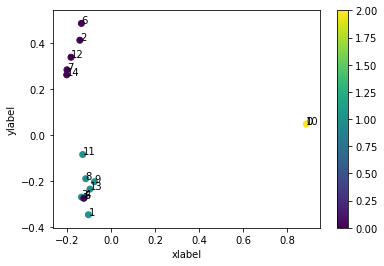

In [9]:
#%matplotlib inline
plt.scatter(transformed[:,0], transformed[:,1],c=labels) # 1列目のデータをx軸の値、2列目のデータをy軸の値として与える。
plt.colorbar()
for i,(x,y) in enumerate(zip(transformed[:,0], transformed[:,1])):
    plt.annotate(str(i),(x,y))
plt.xlabel('xlabel') # x軸
plt.ylabel('ylabel') # y軸
plt.show() 

In [19]:
#文書の順番に作者番号が並んだ作者番号リスト（正解ラベルの1次元配列）を作成
doc_info = pd.read_csv('token_files.csv',encoding='cp932')
#print(doc_info)
files = doc_info['文書'].values
print(files)
author_codes = doc_info['著者コード'].values 
print(author_codes)
#文書ベクトルと作者番号リストを，訓練用とテスト用に分割
#今回は半分に
docs_train    = population[:13]        # 訓練データ
authors_train = author_codes[:13]  # 正解ラベル
docs_test     = population[13:]         # テストデータ
authors_test  = author_codes[13:]   # 正解ラベル

['result_yukionna.txt' 'result_noctilucae.txt' 'result_hashino_uede.txt'
 'result_carlyle_hakubutsukan.txt' 'result_gubijinso.txt'
 'result_ganjitsu.txt' 'result_umi.txt' 'result_itto.txt'
 'result_ichimon_itto.txt' 'result_a_dead_secret.txt' 'result_yukionna.txt'
 'result_aru_chukoku.txt' 'result_at_a_railway_station.txt'
 'result_ichiya.txt' 'result_anitachi.txt']
[0 0 0 1 1 1 2 2 2 0 1 2 0 1 2]


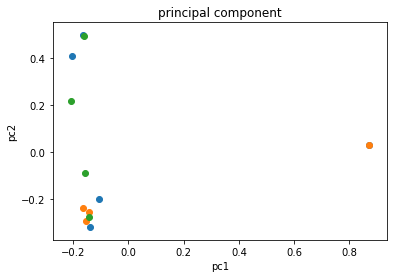

In [20]:
    pca = PCA(n_components=2)
    pca.fit(docs_train)

    # 分析結果を元にデータセットを主成分に変換する
    transformed = pca.fit_transform(docs_train)

    # 主成分をプロットする
    for label in np.unique(authors_train):
        plt.scatter(transformed[authors_train == label, 0],
                    transformed[authors_train == label, 1])
    plt.title('principal component')
    plt.xlabel('pc1')
    plt.ylabel('pc2')

    # 主成分の寄与率を出力する
   # print('各次元の寄与率: {0}'.format(pca.explained_variance_ratio_))
  #  print('累積寄与率: {0}'.format(sum(pca.explained_variance_ratio_)))

    # グラフを表示する
    plt.show()

In [17]:
pca = PCA(n_components=2)
pca.fit(population)


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [6]:
#データのスケーリング（正規化）はtf-idfなのでOK

In [ ]:
#numpy の配列 ndarray のソーティングより

#vectorizer.get_feature_names() 特徴名（単語）
#tfidf_matrix.toarray()  # tf-idfの行列
name_list = np.array(vectorizer.get_feature_names())
population = np.array(tfidf_matrix.toarray())
print(population)
indices = np.argsort(-population)
#品詞を名詞に限定した場合
#大きい値ほど各文書を特徴付ける単語　 値の多い順に20件表示
print(name_list[indices[::,0:20]])

In [ ]:
# tf-idf を重みとする単語文書行列に変換
#resultしたものは名詞限定になっている
t1='result_yukionna.txt'
t2='result_noctilucae.txt'
t3='result_hashino_uede.txt'
t4='result_carlyle_hakubutsukan.txt'
t5='result_gubijinso.txt'
t6='result_ganjitsu.txt'
t7='result_a_dead_secret.txt'
t8='result_at_a_railway_station.txt'
t9='result_ichiya.txt'
t10='result_yukionna.txt'






vectorizer = CountVectorizer(input='filename')
corpus=[t1,t2,t3,t4,t5,t6,t7,t8,t9,t10]  
matrix = vectorizer.fit_transform(corpus)
#print(matrix)
#CountVectorizer で得られた単語文書行列を，TfidfTransformer でtf-idfの行列に変換する
tfidf = TfidfTransformer()#norm='l2'
tfidf_matrix = tfidf.fit_transform(matrix)
np.set_printoptions(precision=2) 

#numpy の配列 ndarray のソーティングより

#vectorizer.get_feature_names() 特徴名（単語）
#tfidf_matrix.toarray()  # tf-idfの行列
name_list = np.array(vectorizer.get_feature_names())
population = np.array(tfidf_matrix.toarray())
print(population)
indices = np.argsort(-population)
#品詞を名詞に限定した場合
#大きい値ほど各文書を特徴付ける単語　 値の多い順に20件表示
#print(name_list[indices[::,0:20]])

In [ ]:
kmeans = KMeans(n_clusters=3).fit(population)     # クラスタ数を指定して，クラスタリング実行
labels = kmeans.labels_        # 各データのクラスタ番号を取得
labels

In [9]:
# 分類器を生成
clf =SVC(kernel='linear',  C=1)#パラメータ設定は
#sklearn.model_selection.GridSearchCV を使った
# 訓練データを使って学習
clf.fit(docs_train, authors_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)